# Diagnosing Bias and Variance

Once we understand the learning algorithm's performance by measuring its training and cross validation error. Given on these values, we are able to quantify how well a model is doing and this helps us make a decision on which one to use for a given application.

**In this project**, we will build upon this process and explore some tips to improve the perfomance of our models. As it turns out, the training and cross validation errors can tell you what to try next to improve our models. 

Specifically, it will show if we have a bias bias (underfitting) or high variance (overfitting) problem.

<img src="Bias and Variance explanation.png" width=75%>

**Problem:**

The *leftmost figure* shows a high bias problem where the model is not capturing the patters in the training data. As a result, we will have a high training and cross validation error.

The *rightmost figure,* on the other hand, shows a high variance problem where the model had overfit the training set. Thus, even though it has a low training error, it will perform poorly on new examples. This is indicated by high cross validation error.

The ideal model would be the *figure in the middle*, where it successfully learn from the training set and also generalizes well to unseen data. 

To **fix a high bias problem**, we can:

* try adding polynomial features
* try getting additional features
* try decreasing the regularization parameter

To **fix a high variance problem**, we can:

* try smaller set of features
* try getting more training examples
* try increasing the regularization parameter

# Establishing the Baseline of Performance

Before you can diagose a model for high bias or high variance, it is usually helful to first have an idea of what level of error you can reasonably get to.

We can use any of the following to set a baseline level of performance.
* Human level performance
* competing algorithm's performance
* guess based on experience

**Real-world data** can be very noisy and it's often infeasible to get to 0% error. For example, you might think that you have a high bias problem because you're getting 10% training and 15% cross validation error on a computer vision application. However, you later found out that even humans can't perform better than 10% error. If you consider this the baseline level, then you now instead have a high variance problem because you've prioritized minimizing the gap between cross validation and training error.

With this in mind, let's begin exploring the techniques to address these issues.

# Imports

In [19]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error


# Fixing High Bias

We will first look at things to try when our model is underfitting. In other words, when the training error is far worse than the baseline level of performance.

### 1st technique: Try adding polynomial features

Adding polynomial features can help your model learn more complex patterns in your data. Here again is an example of a plot showing how the training and cross validation errors change as you add more polynomial features. We will be using a synthetic dataset for a regression problem with one feature and one target. In addition, we will also define an arbitrary baseline performance and include it in the plot.

In [22]:
# Split the dataset into train, cv, and test
def prepare_dataset(filename):
    
    data = np.loadtxt(filename, delimiter=",")
    
    x = data[:,:-1]
    y = data[:,-1]
    
    # Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
    x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=80)

    # Split the 40% subset above into two: one half for cross validation and the other for the test set
    x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=80)
    
    return x_train, y_train, x_cv, y_cv, x_test, y_test


In [23]:
x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset('Datasets/Dataset1.csv')

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")

# Preview the first 5 rows
print(f"first 5 rows of the training inputs (1 feature):\n {x_train[:5]}\n")


the shape of the training set (input) is: (60, 1)
the shape of the training set (target) is: (60,)

the shape of the cross validation set (input) is: (20, 1)
the shape of the cross validation set (target) is: (20,)

first 5 rows of the training inputs (1 feature):
 [[3757.57575758]
 [2878.78787879]
 [3545.45454545]
 [1575.75757576]
 [1666.66666667]]



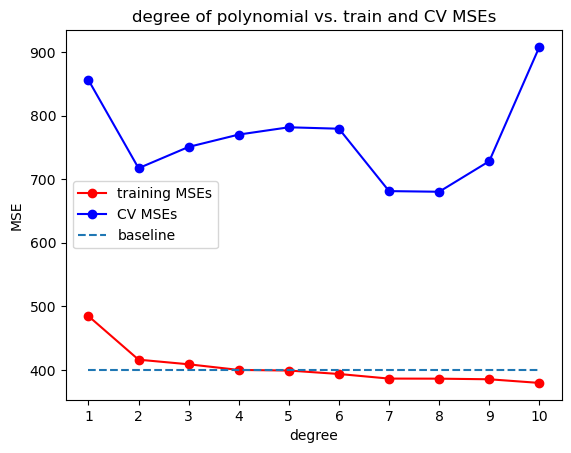

In [25]:
# Instantiate the regression model class
model = LinearRegression()

# Train and plot polynomial regression models
def train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=10, baseline=None):
    
    train_mses = []
    cv_mses = []
    models = []
    scalers = []
    degrees = range(1,max_degree+1)

    # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
    for degree in degrees:

        # Add polynomial features to the training set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_train_mapped = poly.fit_transform(x_train)

        # Scale the training set
        scaler_poly = StandardScaler()
        X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
        scalers.append(scaler_poly)

        # Create and train the model
        model.fit(X_train_mapped_scaled, y_train )
        models.append(model)

        # Compute the training MSE
        yhat = model.predict(X_train_mapped_scaled)
        train_mse = mean_squared_error(y_train, yhat) / 2
        train_mses.append(train_mse)

        # Add polynomial features and scale the cross-validation set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_cv_mapped = poly.fit_transform(x_cv)
        X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

        # Compute the cross-validation MSE
        yhat = model.predict(X_cv_mapped_scaled)
        cv_mse = mean_squared_error(y_cv, yhat) / 2
        cv_mses.append(cv_mse)

    # Plot the results
    plt.plot(degrees, train_mses, marker='o', c='r', label='training MSEs'); 
    plt.plot(degrees, cv_mses, marker='o', c='b', label='CV MSEs'); 
    plt.plot(degrees, np.repeat(baseline, len(degrees)), linestyle='--', label='baseline')
    plt.title("degree of polynomial vs. train and CV MSEs")
    plt.xticks(degrees)
    plt.xlabel("degree"); 
    plt.ylabel("MSE"); 
    plt.legend()
    plt.show()

train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=10, baseline=400)

As you can see, the more polynomial features you add, the better the model fits to the training data. In this example, it even performed better than the baseline. At this point, you can say that the models with degree greater than 4 are low-bias because they perform close to or better than the baseline.

However, if the baseline is defined lower (e.g. you consulted an expert regarding the acceptable error), then the models are still considered high bias. You can then try other methods to improve this.

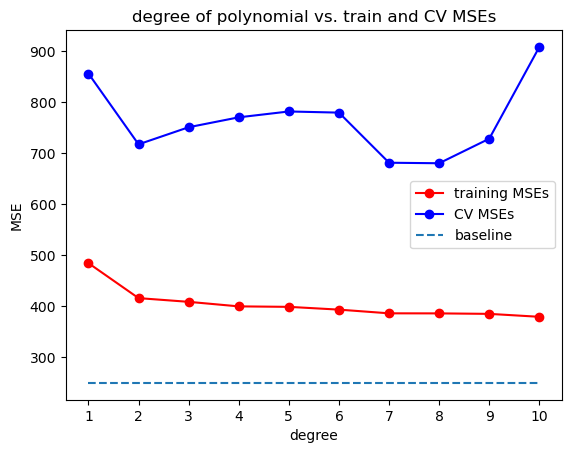

In [21]:
train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=10, baseline=250)

### 2nd technique: Try getting additional features

Another thing you can try is to acquire other features. Let's say that after you got the results above, you decided to launch another data collection campaign that captures another feature. Your dataset will now have 2 columns for the input features as shown below.

In [27]:
x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset('Datasets/Dataset2.csv')

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")

# Preview the first 5 rows
print(f"first 5 rows of the training inputs (2 features):\n {x_train[:5]}\n")

the shape of the training set (input) is: (60, 2)
the shape of the training set (target) is: (60,)

the shape of the cross validation set (input) is: (20, 2)
the shape of the cross validation set (target) is: (20,)

first 5 rows of the training inputs (2 features):
 [[3.75757576e+03 5.49494949e+00]
 [2.87878788e+03 6.70707071e+00]
 [3.54545455e+03 3.71717172e+00]
 [1.57575758e+03 5.97979798e+00]
 [1.66666667e+03 1.61616162e+00]]



Now see what this does to the same training process as before. You'll notice that the training error is now closer to (or even better than) the baseline.

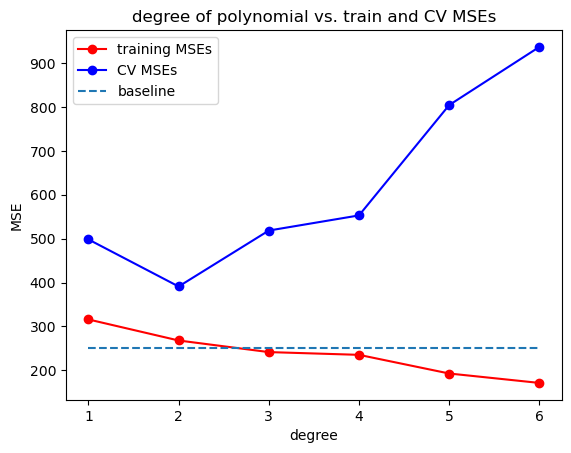

In [28]:
# Train and plot polynomial regression models. Dataset used has two features.
train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=6, baseline=250)

### 3rd technique: Try decreasing the regularization parameter

At this point, you might want to introduce regularization to avoid overfitting. One thing to watch out for is you might make your models underfit if you set the regularization parameter too high. The cell below trains a 4th degree polynomial model using the [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) class which allows you to set a regularization parameter (i.e. lambda or $\lambda$). You will try several values and compare the results.

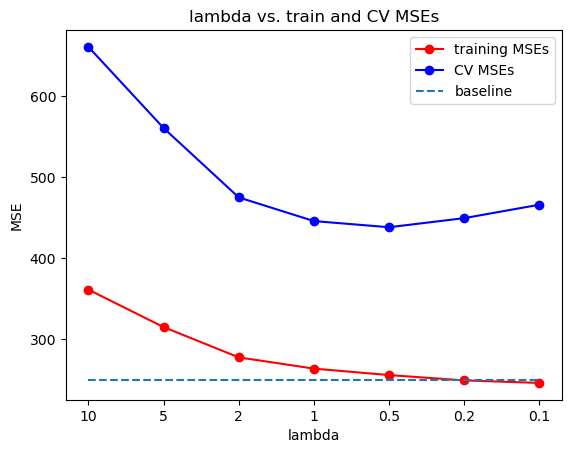

In [34]:
# Define lambdas to plot
reg_params = [10, 5, 2, 1, 0.5, 0.2, 0.1]

def train_plot_reg_params(reg_params, x_train, y_train, x_cv, y_cv, degree= 1, baseline=None):
    
    train_mses = []
    cv_mses = []
    models = []
    scalers = []

    # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
    for reg_param in reg_params:

        # Add polynomial features to the training set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_train_mapped = poly.fit_transform(x_train)

        # Scale the training set
        scaler_poly = StandardScaler()
        X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
        scalers.append(scaler_poly)

        # Create and train the model
        model = Ridge(alpha=reg_param)
        model.fit(X_train_mapped_scaled, y_train)
        models.append(model)

        # Compute the training MSE
        yhat = model.predict(X_train_mapped_scaled)
        train_mse = mean_squared_error(y_train, yhat) / 2
        train_mses.append(train_mse)

        # Add polynomial features and scale the cross-validation set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_cv_mapped = poly.fit_transform(x_cv)
        X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

        # Compute the cross-validation MSE
        yhat = model.predict(X_cv_mapped_scaled)
        cv_mse = mean_squared_error(y_cv, yhat) / 2
        cv_mses.append(cv_mse)

    # Plot the results
    reg_params = [str(x) for x in reg_params]
    plt.plot(reg_params, train_mses, marker='o', c='r', label='training MSEs'); 
    plt.plot(reg_params, cv_mses, marker='o', c='b', label='CV MSEs'); 
    plt.plot(reg_params, np.repeat(baseline, len(reg_params)), linestyle='--', label='baseline')
    plt.title("lambda vs. train and CV MSEs")
    plt.xlabel("lambda"); 
    plt.ylabel("MSE"); 
    plt.legend()
    plt.show()


# Define degree of polynomial and train for each value of lambda
train_plot_reg_params(reg_params, x_train, y_train, x_cv, y_cv, degree= 4, baseline=250)

### Conclusion

The resulting plot shows an initial $\lambda$ of `10` and as you can see, the training error is worse than the baseline at that point. This implies that it is placing a huge penalty on the `w` parameters and this prevents the model from learning more complex patterns in your data. As you decrease $\lambda$, the model loosens this restriction and the training error is able to approach the baseline performance.